---
# <div align="center">**TRY BETTER MODEL (XGB) TO SEE IF COVERAGE_SURE INCREASE**</div>  
---  

---
# <div align="center">**MODEL BEST**</div>  
---  

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

import warnings

from lightgbm import LGBMRegressor
from matplotlib.offsetbox import AnnotationBbox, TextArea
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.subsample import Subsample

In [2]:
pd.set_option('display.max_columns', None)               # Hiển thị đầy đủ bảng với thanh trượt ngang
pd.set_option('display.float_format', '{:,.4f}'.format)  # Làm tròn số hiển thị ở dạng 4 thập phân cho gọn

In [3]:
# Excel gốc bị trống dòng đầu tiên, lấy dòng 2 và 3 làm header
data_raw = pd.read_excel("D:/FOX AI/Project Info/KPI/KPI 2024.xlsx", header=[1,2])

In [4]:
# Tạo cột mới bao gồm các header muốn thay - dạng list (Đối chiếu với file excel cho dễ nhìn)
new_header = ['Tháng', 'CIF CBNV', 'Họ Tên', 
              'Mã ĐVKD', 'Khu vực', 'Đơn vị', 'Chức danh', 'Mã chức danh',     
              'Ngày vào làm việc', 'Giới tính', 'Năm sinh',                   
              'Book Huy động', 'Book Cho vay', 'Net Huy động', 'Net Cho vay',
              'Điểm Book TỔNG HĐ chưa chặn', 'Điểm Book HĐ KỲ HẠN chưa chặn', 'Điểm Book HĐ CASA chưa chặn', 'Điểm Book CV chưa chặn',
              'Điểm Net HĐ', 'Điểm Net CV', 
              'SL KH',
              'KPI_CN Book Value', 'KPI_CN Net Value', 'KPI_CN Điểm DV', 'KPI_CN CLTD/DV',
              'KPI_BP Book Value', 'KPI_BP Net Value', 'KPI_BP Điểm DV', 'KPI_BP CLTD/DV',
              'Tổng điểm CN', 'Tổng điểm BP', 
              'Điểm KH CN', 'Điểm KH BP', 
              'Tỷ trọng KPI_CN', 'Tỷ trọng KPI_BP',
              'Điểm Cộng/Trừ CN', 
              '% KPI_CN', '% KPI_BP', '% KPI cuối cùng', 
              'Thu nhập Gross'
             ]

# Ghi đè cột Header mới đủ 41 biến thay cho Header 1 và 2 MultiIndex, tạo thành dataframe 
data_raw.columns = new_header

# Đổi tên để lưu trữ
df_renamed = data_raw

# # Kiểm tra 
# display(df_renamed.info())

In [5]:
# # Kiểm tra 2
# display(df_renamed.head(3))

In [6]:
"""
0. Tháng                          Thời điểm dòng dữ liệu được ghi nhận vào hệ thống 
1. CIF CBNV                       Mã ID độc lập cho từng người, dùng để truy vấn nếu cần
2. Họ Tên
3. Mã ĐVKD             
4. Khu vực             
5. Đơn vị             
6. Chức danh           
7. Mã chức danh
8. Ngày vào làm việc
9. Giới tính
10. Năm sinh
11. Book Huy Động                 Tổng số tiền huy động được từ khách hàng     (tiền gửi, tiết kiệm, đầu tư)       >> Hiệu suất Thu hút vốn
12. Book Cho Vay                  Tổng số tiền đã giải ngân cho khách hàng vay                                     >> Hiệu suất Cho vay
13. Net Huy Động Vốn              = Book Huy Động Vốn - Số tiền khách rút ra   (Mức tăng trưởng của HĐV)           >> Hiệu suất thu hút tiền gừi
14. Net Cho Vay                   = Book Cho Vay - Số tiền khách trả nợ        (Mức tăng trưởng của Dư nợ cho vay) >> Hiệu suất tín dụng
15. Điểm Book Tổng HĐ chưa chặn   = f0(Book HĐ kỳ hạn, HĐ CASA, HĐ khác...)    (Cách tính tùy theo ngân hàng, hàm đã bị ẩn đi
16. Điểm Book HĐ kỳ hạn chưa chặn = f1(Book HĐ kỳ hạn)                          Cách tính tương tự, chỉ khác hàm: chia mức chuẩn, nhân hệ số,....) 
17. Điểm Book HĐ CASA chưa chặn   = f2(Book HĐ CASA)                                         
18. Điểm Book CV chưa chặn        = f3(Book CV)
19. Điểm Net HĐ                   = f4(Net HĐ)
20. Điểm Net CV                   = f5(Net CV)
21. SL KH
22. KPI_CN Book Value             = g0(Book HĐ, Book CV)                        Vẫn tương tự, hàm đã bị ẩn đi:
23. KPI_CN Net Value              = g1(Net HĐ, Net Value)                                     Thêm chặn, thay trọng số,... 
24. KPI_CN Điểm DV                Điểm Dư Vốn /// Điểm Dịch vụ ???????????                                   
25. KPI_CN CLTD/DV                Cho Lãi Tín Dụng / DV
26. KPI_BP Book Value                                                           Vẫn tương tự, hàm khác nữa bị ẩn đi:
27. KPI_BP Net Value                                                                          Chia cho tổng nào đó của bộ phận, thay trọng số,...    
28. KPI_BP Điểm DV                
29. KPI_BP CLTD/DV                       
30. Tổng điểm CN                  = SUM(22 23 24 25)
31. Tổng điểm BP                  = SUM(26 27 28 29)      
32. Điểm KH CN                    Điểm Kế hoạch Cá nhân
33. Điểm KH BP                    Điểm Kế hoạch Bộ phận
34. Tỷ trọng KPI_CN                    Tỷ trọng cột 34 35 để nhân với cột 37 38 ra cột 39        
35. Tỷ trọng KPI_BP                    Ví dụ: GDV tỷ trọng 1 - 0; Càng cấp cao như GĐ, KSV thì tỷ trọng 0.2 - 0.8 (chính sách ngân hàng tùy tháng)
36. Điểm Cộng/Trừ CN              Cộng vào cột 30 ???
37. % KPI_CN                      = 30 / 32
38. % KPI_BP                      = 31 / 33 
39. % KPI cuối cùng               = 30 * 37 + 35 * 38
40. Thu nhập Gross                Thu nhập trước khi trừ đi các khoản chi phí, thuế, bảo hiểm, v.v khác
"""

'\n0. Tháng                          Thời điểm dòng dữ liệu được ghi nhận vào hệ thống \n1. CIF CBNV                       Mã ID độc lập cho từng người, dùng để truy vấn nếu cần\n2. Họ Tên\n3. Mã ĐVKD             \n4. Khu vực             \n5. Đơn vị             \n6. Chức danh           \n7. Mã chức danh\n8. Ngày vào làm việc\n9. Giới tính\n10. Năm sinh\n11. Book Huy Động                 Tổng số tiền huy động được từ khách hàng     (tiền gửi, tiết kiệm, đầu tư)       >> Hiệu suất Thu hút vốn\n12. Book Cho Vay                  Tổng số tiền đã giải ngân cho khách hàng vay                                     >> Hiệu suất Cho vay\n13. Net Huy Động Vốn              = Book Huy Động Vốn - Số tiền khách rút ra   (Mức tăng trưởng của HĐV)           >> Hiệu suất thu hút tiền gừi\n14. Net Cho Vay                   = Book Cho Vay - Số tiền khách trả nợ        (Mức tăng trưởng của Dư nợ cho vay) >> Hiệu suất tín dụng\n15. Điểm Book Tổng HĐ chưa chặn   = f0(Book HĐ kỳ hạn, HĐ CASA, HĐ khác...)    (Cá

In [7]:
# Tạo bản sao dataframe gọn, tránh ghi đè
df = df_renamed.copy()

# Xóa
df.drop(columns=['CIF CBNV', 'Họ Tên'], inplace=True)

# Xóa biến đỡ phải chuẩn hóa
df.drop(columns=['Tháng', 'Năm sinh', 'Ngày vào làm việc', 'Giới tính'], inplace=True)

# Xóa biến đỡ phải chuẩn hóa 
df.drop(columns=['Mã ĐVKD', 'Khu vực', 'Đơn vị', 'Chức danh', 'Mã chức danh'], inplace=True)

In [8]:
# Ma trận tương quan ban đầu
# df_numeric = df.select_dtypes(include=[np.number])
# corr_matrix = df_numeric.corr()
# plt.figure(figsize=(16,12))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()

In [9]:
# Xóa các biến tương quan quá cao > 0.9
df.drop(columns=['Điểm Book TỔNG HĐ chưa chặn', 'Điểm Book HĐ KỲ HẠN chưa chặn', 'Điểm Book HĐ CASA chưa chặn', 
                 'Điểm Book CV chưa chặn',             
                 'Điểm Net HĐ',                         
                 'Điểm Net CV',                        
                 'KPI_CN Book Value',                   
                 'KPI_CN Net Value',   # Giữ lại 4 cột gốc 'Book Huy động', 'Book cho vay', ' Net Huy động', 'Net Cho vay'
                 'Tỷ trọng KPI_BP'     # Giữ lại 1 cột gốc 'Tỷ trọng KPI_CN'
                ], inplace=True)

# Xóa các biến không tồn tại khi triển khai
df.drop(columns=['Tổng điểm CN', 'Tổng điểm BP', 
                 '% KPI_CN', '% KPI_BP', 
                 'Thu nhập Gross'
                ], inplace=True)

# Xóa biến thiếu ý nghĩa - khoảng 90% giá trị = 0
df.drop(columns=['Điểm Cộng/Trừ CN'], inplace=True)

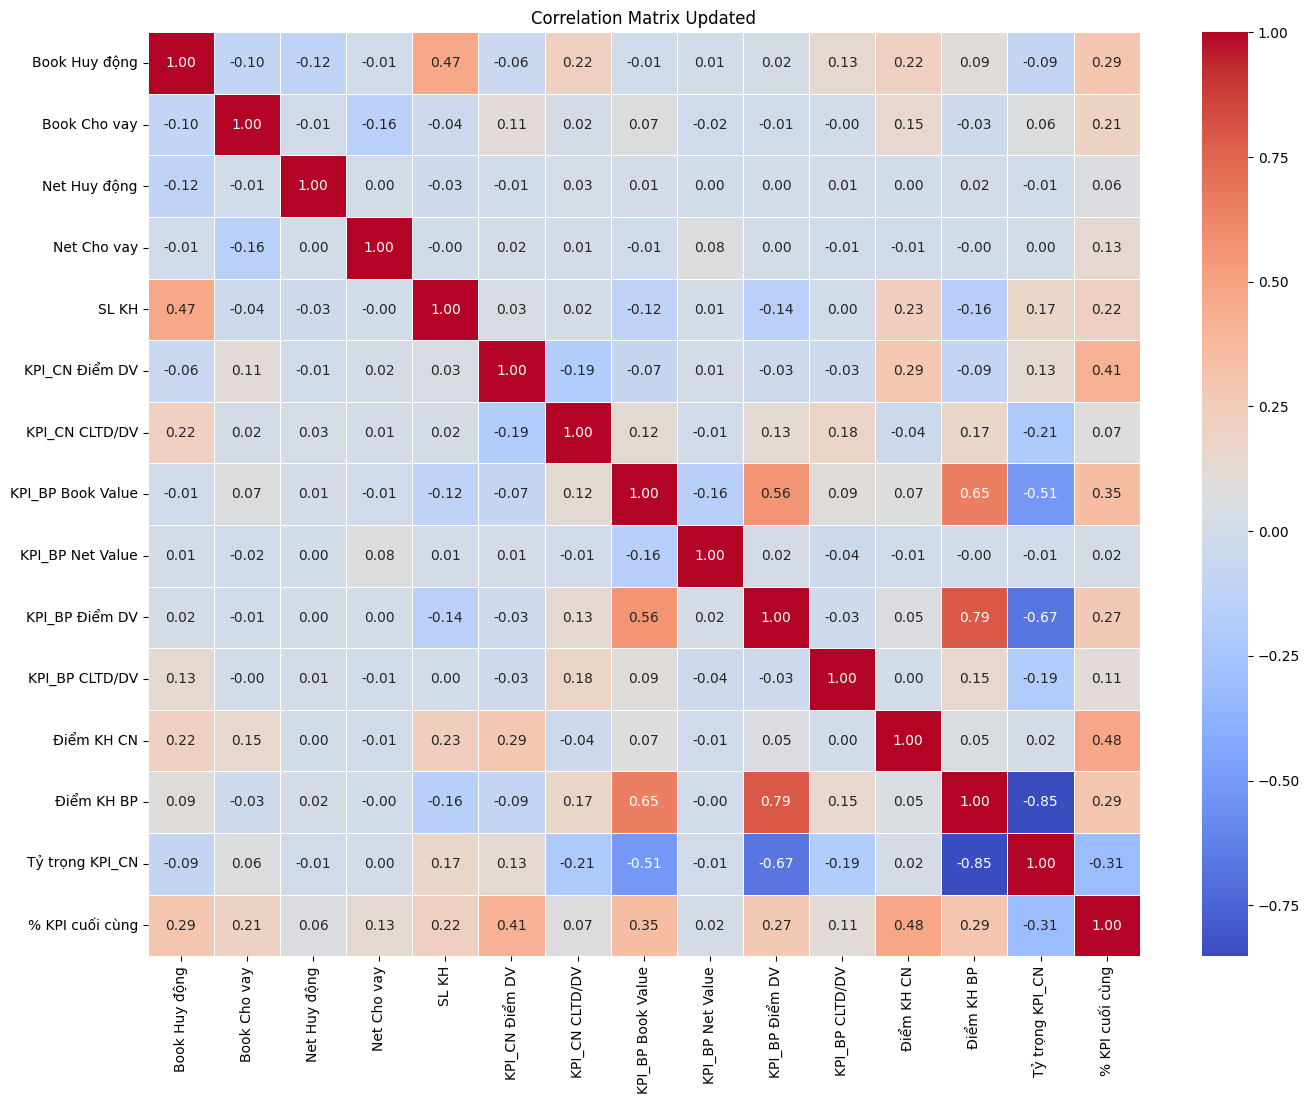

In [10]:
# Ma trận tương quan 2
df_numeric_2 = df.select_dtypes(include=[np.number])
corr_matrix_2 = df_numeric_2.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix_2, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Updated')
plt.show()

In [11]:
cols_to_keep = [
    "Book Huy động",       
    "Book Cho vay",
    "Net Huy động",
    "Net Cho vay",
    "SL KH",
    "KPI_CN Điểm DV",   # Comment để xóa nhanh các cột và thử nghiệm
    "KPI_CN CLTD/DV",
    "KPI_BP Book Value",
    "KPI_BP Net Value",
    "KPI_BP Điểm DV",
    "KPI_BP CLTD/DV",
    "Điểm KH CN",
    "Điểm KH BP",
    "Tỷ trọng KPI_CN",
    "% KPI cuối cùng",  # Target
]

# Tạo dataframe mới từ các cột đã chọn
df1 = df[cols_to_keep].copy()

In [12]:
# 1. Tách X, y
X = df1.drop(columns=["% KPI cuối cùng"])
y = df1["% KPI cuối cùng"]

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit mô hình XGB
model_1 = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.07,
    max_depth=7,
    n_estimators=250,
    subsample=0.8,
    random_state=42,
    verbosity=0
)
model_1.fit(X_train, y_train)
y_pred_model_1 = model_1.predict(X_test)

# Fit mô hình LGBM với quantile
model_2 = LGBMRegressor(
    objective="quantile",
    alpha=0.5,
    learning_rate=0.15,
    n_estimators=250,
    max_depth=7,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)
model_2.fit(X_train, y_train)
y_pred_model_2 = model_2.predict(X_test)

# Tạo bảng kết quả
results = pd.DataFrame({
    "Model": ["Model 1", "Model 2"],
    "R² Test": [
        r2_score(y_test, y_pred_model_1),
        r2_score(y_test, y_pred_model_2),
    ],
    "MAE Test": [
        mean_absolute_error(y_test, y_pred_model_1),
        mean_absolute_error(y_test, y_pred_model_2),
    ],
    "RMSE Test": [
        root_mean_squared_error(y_test, y_pred_model_1),
        root_mean_squared_error(y_test, y_pred_model_2),
    ]
})
results

,Model,R² Test,MAE Test,RMSE Test
0,Model 1,0.9719,0.0342,0.0676
1,Model 2,0.9605,0.0408,0.0801


---
# <div align="center">**COMPARE ALL ALPHA OF METHOD PLUS**</div>  
---  

In [13]:
# --- CV_PLUS STRATEGY ---
mapie_plus = MapieRegressor(
    estimator=model_1,
    method="plus",
    cv=10,
    random_state=42
)
mapie_plus.fit(X_train, y_train)

MapieRegressor(cv=10,
               estimator=XGBRegressor(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=0.8, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      feature_weights=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=0.07, max_bin=None,
                                      max_cat_threshold=None,
                                      max_cat_to_onehot=None,
                                      max_delta_step=None, max_depth=7,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=250,
                                      n_jobs=None, num_parallel_tree=None, ...),
               random_state=42)

In [14]:
### CÁCH VIẾT CHUẨN BẢN CHẤT
### CÁCH VIẾT CHUẨN BẢN CHẤT
### CÁCH VIẾT CHUẨN BẢN CHẤT
### CÁCH VIẾT CHUẨN BẢN CHẤT
### CÁCH VIẾT CHUẨN BẢN CHẤT

# ----------------- PLUS STRATEGY – 3‑way break‑down (logic tay kiểm chứng) -----------------
width_thr   = 0.1
alpha_range = np.arange(0.01, 0.51, 0.01)

_, y_pis_plus_all = mapie_plus.predict(X_test, alpha=alpha_range)
n_test = len(y_test)

records = []

for i, alpha in enumerate(alpha_range):
    # --- fix ill‑sorted bounds ---
    low = np.minimum(y_pis_plus_all[:, 0, i], y_pis_plus_all[:, 1, i])
    up  = np.maximum(y_pis_plus_all[:, 0, i], y_pis_plus_all[:, 1, i])
    w   = up - low

    # --- đánh giá toàn tập ---
    mask_hit  = (y_test >= low) & (y_test <= up)
    mask_miss = ~mask_hit

    coverage_all = mask_hit.mean()
    mean_width   = w.mean()

    # --- 3 nhánh theo logic gốc ---
    mask_le = w <= width_thr
    mask_gt = ~mask_le

    sure    = np.sum(mask_le & mask_hit)     # đúng & width nhỏ
    wrong   = np.sum(mask_le & mask_miss)    # sai & width nhỏ
    review  = np.sum(mask_gt)                # width lớn

    # --- tỷ lệ tính trực tiếp ---
    pct_sure    = sure / n_test
    pct_wrong   = wrong / n_test
    pct_review  = review / n_test

    records.append({
        "alpha":           alpha,
        "coverage_all":    coverage_all,
        "mean_width_all":  mean_width,
        "pct_width≤0.1":   mask_le.mean(),
        "%_sure":          pct_sure,
        "%_wrong":         pct_wrong,
        "%_review":        pct_review,
        "%_checkall":      pct_sure + pct_wrong + pct_review
    })

# --- DataFrame kết quả ---
df_plus_tradeoff = pd.DataFrame(records)


In [15]:
# # --- Style hiển thị đẹp ---
# styled_tradeoff = (
#     df_plus_tradeoff.style
#     .format({
#         'alpha' :'{:.2f}',
#         'coverage_all': '{:.4f}',
#         'mean_width_all': '{:.4f}',
#         'pct_width≤0.1': '{:.2%}',
#         '%_sure': '{:.2%}',
#         '%_wrong': '{:.2%}',
#         '%_review': '{:.2%}',
#         '%_checkall': '{:.2%}',
#     })
# )

# display(styled_tradeoff)

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Lấy lại DataFrame gốc
df = df_plus_tradeoff.data if hasattr(df_plus_tradeoff, "data") else df_plus_tradeoff
styled_df = df.copy()

# tìm dòng có %_sure cao nhất
winner_idx = styled_df['%_sure'].idxmax()
winner_color = "Blue"  

# style heatmap
styled_plus_tradeoff = (
    styled_df.style
    .background_gradient(
        subset=['%_sure'],
        cmap=plt.get_cmap('Greens'),
        vmin=styled_df['%_sure'].min(),
        vmax=styled_df['%_sure'].max()
    )
    .apply(
        lambda s: [
            f'background-color: {winner_color}' if s.name == winner_idx else ''
            for _ in s
        ],
        axis=1
    )
    .format({
        'alpha' :'{:.2f}',
        'coverage_all': '{:.4f}',
        'mean_width_all': '{:.4f}',
        'pct_width≤0.1': '{:.2%}',
        '%_sure': '{:.2%}',
        '%_wrong': '{:.2%}',
        '%_review': '{:.2%}',
        '%_checkall': '{:.2%}',
    })
)

display(styled_plus_tradeoff)

,alpha,coverage_all,mean_width_all,pct_width≤0.1,%_sure,%_wrong,%_review,%_checkall
0,0.01,0.9918,0.6003,0.00%,0.00%,0.00%,100.00%,100.00%
1,0.02,0.9822,0.4171,0.00%,0.00%,0.00%,100.00%,100.00%
2,0.03,0.9744,0.3239,0.00%,0.00%,0.00%,100.00%,100.00%
3,0.04,0.9677,0.2718,0.00%,0.00%,0.00%,100.00%,100.00%
4,0.05,0.9606,0.2379,0.00%,0.00%,0.00%,100.00%,100.00%
5,0.06,0.9542,0.2147,0.00%,0.00%,0.00%,100.00%,100.00%
6,0.07,0.9467,0.1968,0.00%,0.00%,0.00%,100.00%,100.00%
7,0.08,0.9393,0.1826,0.00%,0.00%,0.00%,100.00%,100.00%
8,0.09,0.9304,0.1703,0.00%,0.00%,0.00%,100.00%,100.00%
9,0.10,0.9240,0.1600,0.00%,0.00%,0.00%,100.00%,100.00%


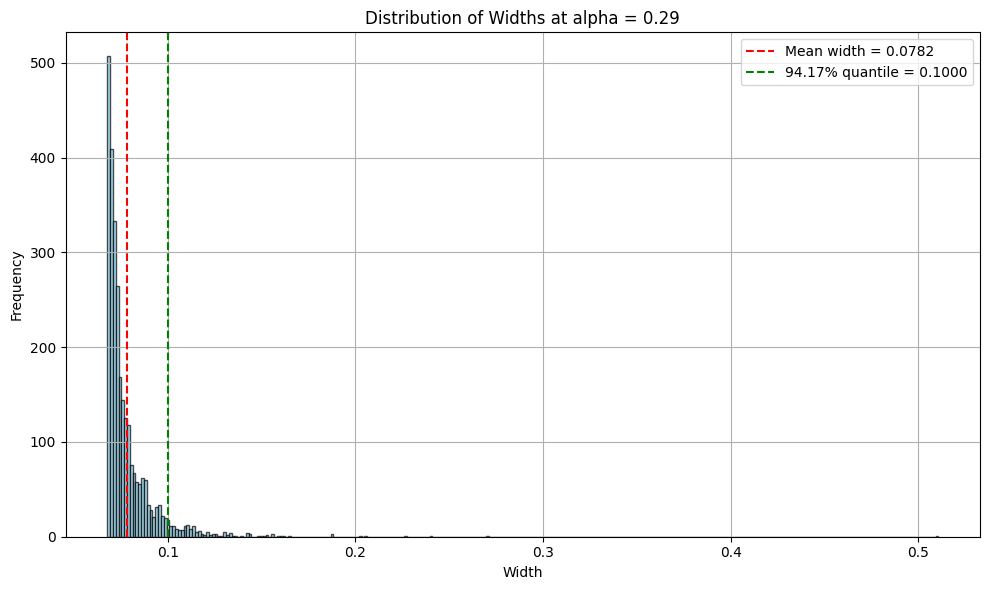

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- ALPHA tốt nhất ---
alpha_best = 0.29
i_best = np.where(np.isclose(alpha_range, alpha_best))[0][0]

# --- lấy bound tương ứng ---
low = np.minimum(y_pis_plus_all[:, 0, i_best], y_pis_plus_all[:, 1, i_best])
up  = np.maximum(y_pis_plus_all[:, 0, i_best], y_pis_plus_all[:, 1, i_best])
w   = up - low

# --- tính mean và phân vị ---
mean_w = np.mean(w)
q  = np.quantile(w, 0.9417)

# --- vẽ ---
plt.figure(figsize=(10, 6))
plt.hist(w, bins="auto", color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_w, color='red', linestyle='--', label=f"Mean width = {mean_w:.4f}")
plt.axvline(q, color='green', linestyle='--', label=f"94.17% quantile = {q:.4f}")

plt.title(f"Distribution of Widths at alpha = {alpha_best}")
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

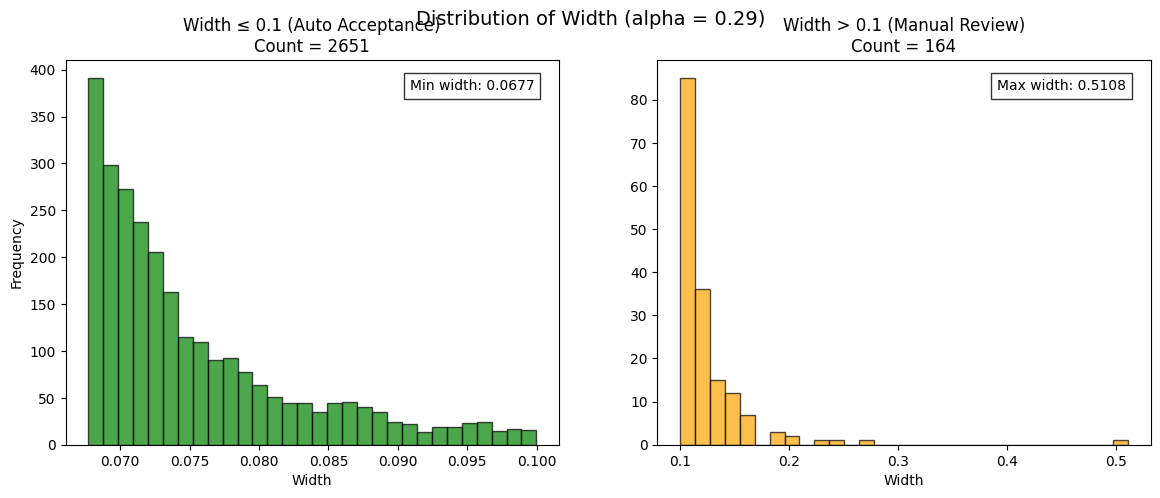

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# --- ALPHA tốt nhất ---
alpha_best = 0.29
i_best = np.where(np.isclose(alpha_range, alpha_best))[0][0]

# --- tính width ---
low = np.minimum(y_pis_plus_all[:, 0, i_best], y_pis_plus_all[:, 1, i_best])
up  = np.maximum(y_pis_plus_all[:, 0, i_best], y_pis_plus_all[:, 1, i_best])
w   = up - low

# --- tách 2 nhóm ---
w_le = w[w <= 0.1]     # width ≤ 0.1
w_gt = w[w > 0.1]      # width > 0.1

count_le = len(w_le)
count_gt = len(w_gt)
min_w_le = w_le.min()
max_w_gt = w_gt.max()

# --- vẽ 2 subplot ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Subplot 1: width ≤ 0.1 ---
axs[0].hist(w_le, bins=30, color='green', edgecolor='black', alpha=0.7)
axs[0].set_title(f"Width ≤ 0.1 (Auto Acceptance)\nCount = {count_le}")
axs[0].set_xlabel("Width")
axs[0].set_ylabel("Frequency")
axs[0].text(
    0.95, 0.95, f"Min width: {min_w_le:.4f}",
    ha='right', va='top', transform=axs[0].transAxes,
    fontsize=10, bbox=dict(facecolor='white', alpha=0.8)
)

# --- Subplot 2: width > 0.1 ---
axs[1].hist(w_gt, bins=30, color='orange', edgecolor='black', alpha=0.7)
axs[1].set_title(f"Width > 0.1 (Manual Review)\nCount = {count_gt}")
axs[1].set_xlabel("Width")
axs[1].text(
    0.95, 0.95, f"Max width: {max_w_gt:.4f}",
    ha='right', va='top', transform=axs[1].transAxes,
    fontsize=10, bbox=dict(facecolor='white', alpha=0.8)
)

plt.suptitle(f"Distribution of Width (alpha = {alpha_best})", fontsize=14)

plt.show()
